In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [1]:
import tensorflow as tf
import keras
import pandas as pd
import os
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img
from keras.applications.mobilenet import MobileNet
from tensorflow.keras.optimizers import Adam
from keras.models import Model,load_model
from keras.layers import Dense,GlobalAveragePooling2D,Dropout,Reshape,Conv2D
from keras.applications.mobilenet import preprocess_input
import h5py
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,ConfusionMatrixDisplay
import numpy as np
from IPython.display import display
import IPython.display
import ipywidgets as widgets
from imutils.video import VideoStream, FPS
import imutils
import cv2

In [4]:

# Augment the existing dataset 
ImageDataGenerator(
    featurewise_center=True,
    samplewise_center=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=None,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=None,
    preprocessing_function=preprocess_input,
    validation_split=0.1,
)

In [4]:

# training and validation split
#gen = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.1)
#gen.flow_from_directory('drive/My Drive/Final year project/disease_data/train')
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [11]:

## Creating the Model
# Modifying Output layer and transfering weights
mobile = MobileNet(weights=None,include_top=True,classes=46)
mobile2 = MobileNet(weights='imagenet',include_top = True)

17235968/17225924 [==============================] - 1s 0us/step


In [12]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [14]:
for i,j in zip(mobile.layers[:-5],mobile2.layers[:-5]):
  i.set_weights(j.get_weights())

In [15]:
for i in mobile.layers[:24]:
  i.trainable=False
for i in mobile.layers[24:]:
  i.trainable=True
for i in mobile.layers:
  print(i.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
#mobile.save('drive/My Drive/Colab Notebooks/mobile.h5')

In [17]:

# Create data generators
train_data = gen.flow_from_directory('drive/My Drive/Final year project/disease_data/train',target_size=(224,224),batch_size=32,class_mode='categorical',color_mode='rgb',subset='training')

Found 93509 images belonging to 46 classes.


In [18]:
val_data = gen.flow_from_directory('drive/My Drive/Final year project/disease_data/train',target_size=(224,224),batch_size=32,class_mode='categorical',color_mode='rgb',subset='validation')

Found 10382 images belonging to 46 classes.


In [5]:
test_data = test_gen.flow_from_directory('test',target_size=(224,224),batch_size=32,shuffle=False)

Found 421 images belonging to 46 classes.


In [2]:
mobile = load_model('model1.hdf5')

In [36]:

# Configuring the model
mobile.compile(Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [26]:
train_steps = train_data.n//train_data.batch_size
val_steps = val_data.n//val_data.batch_size
callback1 = keras.callbacks.TensorBoard(log_dir='drive/My Drive/Colab Notebooks/logs', histogram_freq=0, write_graph=True, write_images=True)
callback2 = keras.callbacks.ModelCheckpoint('drive/My Drive/Colab Notebooks/checkpoints/model.{epoch:02d}-{val_acc:.2f}.hdf5', monitor='val_acc', verbose=1)

In [ ]:

# Training the model
mobile.fit_generator(train_data,steps_per_epoch=train_steps,epochs=6,validation_data=val_data,validation_steps=val_steps,callbacks=[callback1,callback2],verbose=1)

In [ ]:

# Save the model
mobile.save('drive/My Drive/Colab Notebooks/model1.h5')

In [31]:
mobile.history.history

In [6]:
# Evaluating the model
loss,acc = mobile.evaluate(test_data,steps=test_data.n)
print(loss,acc)

421/421 [==============================] - 5s 9ms/step - loss: 0.4172 - accuracy: 0.9145
0.4171987771987915 0.9144893288612366


In [7]:
preds = mobile.predict(test_data)

In [8]:
predictions = np.argmax(preds,axis=1)

In [9]:

# Create Array of class labels
arr = np.array([])
for i in range(8):
  for j in range(10):
    arr = np.append(arr,i)
for i in range(2):
  arr = np.append(arr,8)
for i in range(3):
  arr = np.append(arr,9)
for i in range(10,29):
  for j in range(10):
    arr = np.append(arr,i)
for i in range(29,32):
  for j in range(2):
    arr = np.append(arr,i)
for i in range(32,46):
  for j in range(10):
    arr = np.append(arr,i)
arr = arr.astype(int)
print(arr.shape)

(421,)


In [10]:
lbls = test_data.class_indices
x = list(lbls.keys())
x

['Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___Scab',
 'Apple___healthy',
 'Background_without_leaves',
 'Blueberry___healthy',
 'Cherry___Powdery_mildew',
 'Cherry___healthy',
 'Citrus___Black_spot',
 'Citrus___Canker',
 'Citrus___Greening',
 'Citrus___Melanose',
 'Citrus___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Maize___Cercospora_leaf_spot_gray_leaf_spot',
 'Maize___Common_rust',
 'Maize___Northern_leaf_blight',
 'Maize___healthy',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper_bell___Bacterial_spot',
 'Pepper_bell___healthy',
 'Potato___Early_blight',
 'Potato___Leaf_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Rice___Bacterial_leaf_blight',
 'Rice___Brown_spot',
 'Rice___Leaf_smut',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_b

Confusion matrix


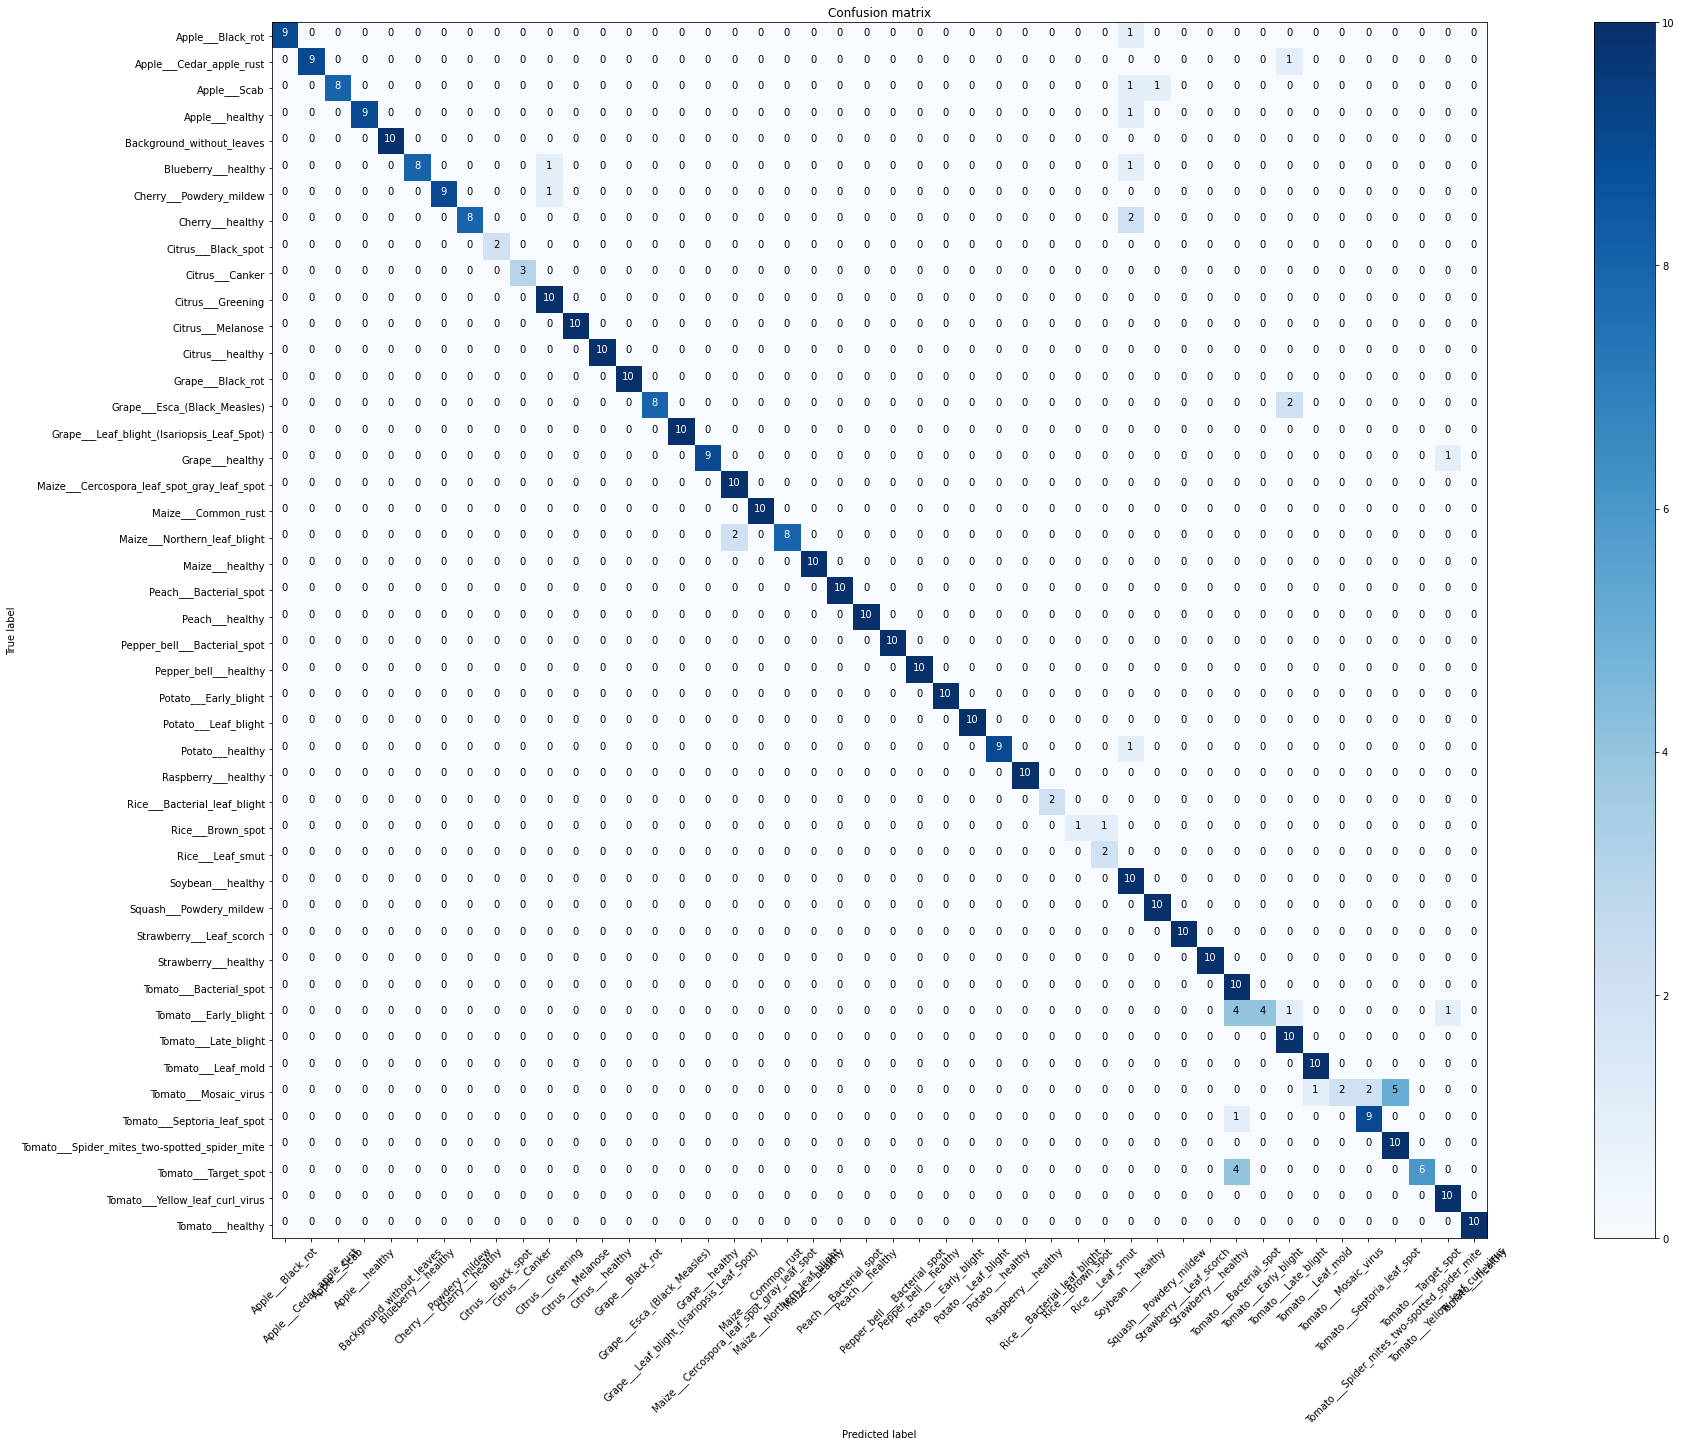

In [11]:

# Confusion Matrix display
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

np.set_printoptions(precision=2)

plt.figure(figsize=(30,20))
mat = confusion_matrix(arr,predictions)
plot_confusion_matrix(mat, classes=x)
plt.show()

## Test Images and Outputs

In [29]:
app_test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
app_test_data = app_test_gen.flow_from_directory('app_test',target_size=(224,224),batch_size=1,shuffle=False)
app_preds = mobile.predict(app_test_data)
app_predictions = np.argmax(app_preds,axis=1)
app_predictions

Found 4 images belonging to 1 classes.


array([ 8,  8, 20, 33], dtype=int64)

### 1. Citrus Black Spot

In [16]:
index = 0

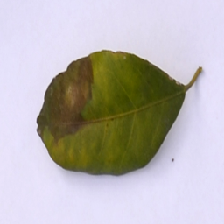

In [17]:
img = array_to_img(app_test_data[index][0][0])
img

In [18]:
x[app_predictions[index]]

'Citrus___Black_spot'

### 2. Citrus Black Spot

In [19]:
index = 1

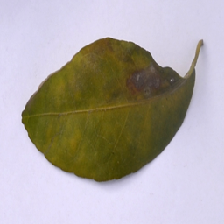

In [20]:
img = array_to_img(app_test_data[index][0][0])
img

In [21]:
x[app_predictions[index]]

'Citrus___Black_spot'

### 3. Maize Healthy

In [22]:
index = 2

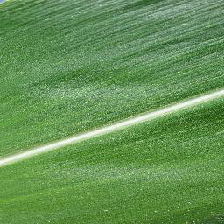

In [23]:
img = array_to_img(app_test_data[index][0][0])
img

In [24]:
x[app_predictions[index]]

'Maize___healthy'

### Squash Powdery Mildew

In [25]:
index = 3

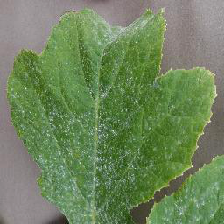

In [26]:
img = array_to_img(app_test_data[index][0][0])
img

In [27]:
x[app_predictions[index]]

'Squash___Powdery_mildew'

## Conversion to Tensorflow Lite

In [46]:
mobile = tf.keras.models.load_model('drive/My Drive/Colab Notebooks/checkpoints/model1.hdf5')

# Tflite Conversion
converter = tf.lite.TFLiteConverter.from_keras_model(mobile)
tflite_model = converter.convert()
tflite_model_name = "drive/My Drive/Colab Notebooks/model.tflite"
open(tflite_model_name, "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpzoscwfhx/assets


INFO:tensorflow:Assets written to: /tmp/tmpzoscwfhx/assets


12993436

In [47]:

# Test for proper creation of Tflite
interpreter = tf.lite.Interpreter(model_path="drive/My Drive/Colab Notebooks/model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[3.07e-10 1.60e-08 2.57e-05 1.67e-04 8.08e-01 2.98e-05 4.04e-05 1.08e-05
  1.92e-01 3.75e-09 9.51e-07 3.62e-06 4.86e-06 1.55e-12 1.27e-16 1.56e-18
  2.95e-15 1.90e-07 2.99e-07 6.01e-08 1.44e-05 4.94e-05 1.17e-09 3.38e-09
  9.05e-08 1.22e-11 1.91e-12 1.99e-10 7.24e-12 4.93e-05 6.84e-06 8.96e-06
  1.99e-09 2.36e-06 2.64e-08 1.62e-08 1.59e-12 1.71e-11 8.95e-07 2.70e-06
  1.06e-07 2.53e-07 4.66e-07 2.75e-09 1.70e-08 7.31e-07]]
